# 오디오 데이터의 디지털화

In [1]:
# 아날로그 신호의 표본화(Sampling)
import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequecy, sampling_rate=16000, duration=1):
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

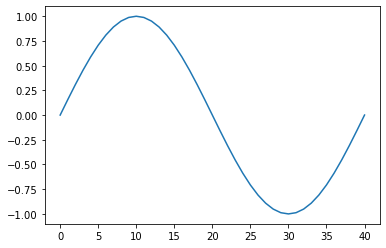

In [2]:
# 사인함수 1 사이클 (연속시간 연속크기)
plt.plot(y[:41])
plt.show()

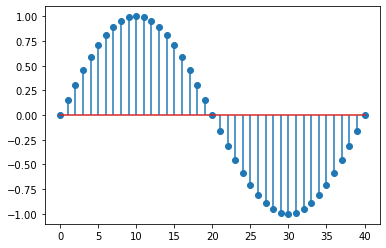

In [3]:
# 표본화(Sampling)를 통해 이산 신호(discrete signal)로 변환된 사인함수
plt.stem(y[:41])
plt.show()

# Speech Recognition 실습
## 1. Wave data 분석
### 1-1. 데이터셋 살펴보기
- 캐글의 음성 인식 챌린지 데이터: "wav_vals", "label_vals"로 구성
- 1초 길이의 오디오 음성데이터 50620개
- 각각의 데이터는 Sample rate 8000으로 re-sampling 되어 있음

In [4]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [5]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  43375
Wave data shape :  (8000,)
label :  ['unknown']


## 2. Train/Test 데이터셋 구성하기
### 2-1. Label data 처리

In [6]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

# unknown, silence label 추가
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

# {단어:인덱스}로 라벨에 index 부여
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [7]:
# 텍스트 label을 인덱스 형태로 변환
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

### 2-2. 학습을 위한 데이터 분리

In [8]:
from sklearn.model_selection import train_test_split

# train data와 test data 분리 (test_size 조절 가능)
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])

[[-1.1945036e-03 -4.2371815e-03 -6.3283737e-03 ... -7.6412708e-03
  -5.0456915e-03 -4.4668792e-03]
 [ 2.2237448e-03  3.3010133e-03 -1.4288229e-03 ...  4.1532861e-03
   3.5558981e-03 -3.4847541e-04]
 [ 3.2810541e-03  4.7639804e-03  8.1694794e-05 ...  2.5750310e-03
   2.0551176e-03 -1.8606179e-03]
 ...
 [-1.0586880e-03 -1.2592181e-03  1.0869687e-03 ...  3.5627375e-03
   3.3297355e-03  3.6013359e-03]
 [ 3.4712090e-03  4.9681468e-03  2.3267497e-04 ...  3.0162206e-03
   2.4416889e-03 -1.5840664e-03]
 [-8.4878545e-04 -2.6761293e-03 -3.1958523e-03 ...  3.6880642e-03
   2.5904712e-03  1.6225034e-03]]


In [9]:
# 나눠진 데이터셋 확인
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)


### 2-3. Hyper-parameters setting

In [10]:
# 하이퍼파라미터 설정
batch_size = 32
max_epochs = 10

# 모델 체크포인트 저장을 위한 save point 경로 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'
checkpoint_dir

'/home/ssac21/aiffel/speech_recognition/models/wav'

### 2-4. Data setting
- `tf.data.Dataset`: 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해주는 데이터셋 관리 패키지
- `tf.data.Dataset.from_tensor_slices`: return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
- `map`: 데이터를 불러올 때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 함수

In [11]:
# map 함수에 넘겨줄 데이터 전처리 함수 작성
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [12]:
# tf.data.Dataset 함수 구성
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 3. Wave classification 모델 구현
### 3-1. Model 구성
- Audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델을 구성해주어야 함
- Conv1D layer, batch norm, dropout, dense layer 등을 이용해 모델 구성

In [13]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

### 3-2. Loss
- 12개의 class로 분류하기 위한 Categorical Cross-Entropy loss 사용

In [14]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 3-3. Training
- `Model Checkpoint callback`: 모델 학습을 진행할 때 fit 함수 내 다양한 인자를 지정해 모니터하며 학습 중간에 원하는 동작을 하도록 설정
- 아래 모델은 validation loss를 모니터하여 loss가 낮아지면 모델 파라미터를 저장하도록 구성

In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [16]:
# 30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.4690 - accuracy: 0.5053
Epoch 00001: val_loss improved from inf to 1.12519, saving model to /home/ssac21/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 161s 113ms/step - loss: 1.4690 - accuracy: 0.5053 - val_loss: 1.1252 - val_accuracy: 0.6351
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.8043 - accuracy: 0.7484
Epoch 00002: val_loss improved from 1.12519 to 0.75812, saving model to /home/ssac21/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 160s 113ms/step - loss: 0.8043 - accuracy: 0.7484 - val_loss: 0.7581 - val_accuracy: 0.7488
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.5265 - accuracy: 0.8409
Epoch 00003: val_loss improved from 0.75812 to 0.50973, saving model to /home/ssac21/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 165s 116ms/step - loss: 0

### 3-4. 학습 결과 시각화
- fit 함수에서 전달 받은 Loss와 Accuracy의 값을 그래프로 표현
- train loss와 val_loss의 차이가 커지는 경우 오버피팅이므로 수정 필요

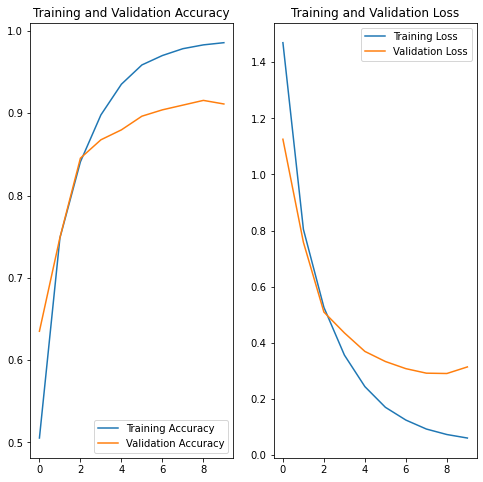

In [17]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3-5. Evaluation
- Test dataset으로 모델의 성능 평가

In [18]:
# checkpoint callback 함수가 저장한 weight 불러오기
model_wav.load_weights(checkpoint_dir)

# Test data로 모델의 예측값과 실제값의 일치 정도 확인
results = model_wav.evaluate(test_dataset)

159/159 [==============================] - 14s 85ms/step - loss: 0.2906 - accuracy: 0.9156


In [19]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.291
accuracy value: 91.5646%


### 3-6. Model Test

In [20]:
# Test data를 랜덤으로 골라 직접 들어보고 모델의 예측이 맞는지 확인
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  on


In [21]:
# 위 테스트셋의 라벨과 모델의 실제 prediction 결과 비교
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: on(Correct!)


## 4. Skip-Connection model 추가
### 4-1. Model 구성
- Skip-connection: 위쪽의 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해지는 방식
- 구현 방법: `tf.concat([#layer output tensor, layer output tensor#], axis=#)`

In [22]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________________________

### 4-2. Loss

In [23]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 4-3. Training

In [24]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [25]:
# 30분 내외 소요 (메모리 사용량 주의)
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.2376 - accuracy: 0.6012
Epoch 00001: val_loss improved from inf to 0.82130, saving model to /home/ssac21/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 172s 121ms/step - loss: 1.2376 - accuracy: 0.6012 - val_loss: 0.8213 - val_accuracy: 0.7437
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.8082
Epoch 00002: val_loss improved from 0.82130 to 0.58846, saving model to /home/ssac21/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 172s 121ms/step - loss: 0.6513 - accuracy: 0.8082 - val_loss: 0.5885 - val_accuracy: 0.8163
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.9066
Epoch 00003: val_loss improved from 0.58846 to 0.44625, saving model to /home/ssac21/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 177s 125ms

### 4-4. 학습 결과 시각화

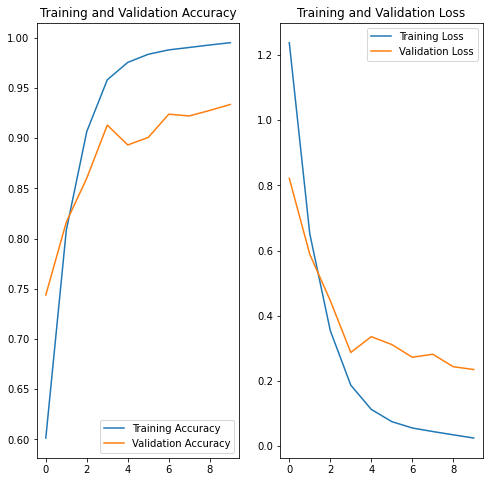

In [26]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4-5. Evaluation

In [27]:
model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 9s 55ms/step - loss: 0.2346 - accuracy: 0.9336
loss value: 0.235
accuracy value: 93.3623%


### 4-6. Modet Test

In [28]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  off


In [29]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: off(Correct!)


## 5. Spectrogram
- 일정 시간동안 wav 데이터 안에 다양한 주파수들이 얼마나 포함되어 있는지 시각화
- X축은 시간, Y축은 주파수를 나타내며, 해당 시간/주파수에서의 음파 강도에 따라 밝은색으로 표현
- wav 데이터가 단위 시간만큼 STFT(Short Time Fourier Transform)을 진행해 매 순간의 주파수 데이터를 얻음

In [33]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [34]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


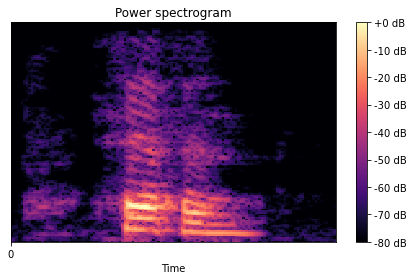

In [35]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()